In [1]:
import sys
import glob
import yaml
import h5py
import pyart
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from analysis import *
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [15]:
win=100
nbasis=15
exp = 'nat8a'
stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
motifs = stim_info.motif.unique()
gap_info = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop','full']]
gap_info['early'] = False
gap_info.loc[gap_info.groupby('motif').apply(
    lambda x: x.gap_start.idxmin()
).values, 'early'] = True

with open(f"../inputs/nat8-familiarity-coding.yml") as famfile:
    familiarity = yaml.safe_load(famfile)
with open(f'../inputs/nat8-stimulus-coding.yml') as coding:
    names = yaml.safe_load(coding)
    names = pd.DataFrame.from_dict(names).stack().to_frame('nat8b').droplevel(0)

In [16]:
gap_times.head()

gap_start  gap_stop   full  early
motif gap                                   
B189  1.0      113.0     209.0   True   True
      2.0      456.0     556.0  False  False
B2    1.0      748.0     824.0  False  False
      2.0      354.0     432.0   True   True
B30   1.0      329.0     402.0  False  False

In [17]:
names

,nat8b
B189,nat8mk0
R56,nat8mk1
R180,nat8mk2
B30,nat8mk3
B72,nat8mk4
B2,nat8mk5
O129,nat8mk6
R253,nat8mk7


In [5]:
conditions = ['C','G','CB','GB','N']
comparisons = [('GB','CB'),('GB','C'),('GB','N')]
cscores = []

dset = 'alpha'
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
root_resps = pd.read_hdf(f"../build/{exp}/{dset}_delemb_win{win}_basis{nbasis}.h5", key="Induction")    
for dataset in ['178B', '180B']:
    with open(f'../inputs/units/{exp}-{dset}-{dataset}.txt') as unitfile:
        set_units = unitfile.read().split('\n')
        set_units = [u for u in set_units if u!='']
    responses = root_resps[set_units]
    models = joblib.load(f"../ouput/{exp}/{dataset}_PLS_models.pkl")
    set_fam = familiarity[exp][dataset]
    _, cs = get_scores(
        exp, models, spectrograms, responses, motifs, None,
        conditions, comparisons, full=False
    )
    cs.loc[cs.motif.isin(set_fam['familiar']), 'fam'] = 'familiar'
    cs.loc[cs.motif.isin(set_fam['unfamiliar']), 'fam'] = 'unfamiliar'
    cscores.append(cs.copy())

Exp nat8a best # of components is 11
Exp nat8a best # of components is 11


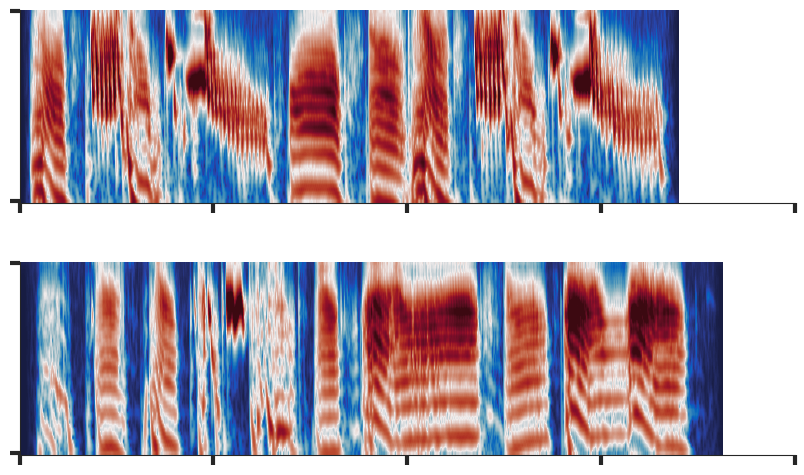

In [6]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.minor.width'] = 2

fig, ax = plt.subplots(2,1, figsize=(10,6))

for im, m in enumerate(motifs[4:6]):
    # ax = plt.figure(figsize=(10,3)).add_subplot()
    stim = aname(m, 'C', 0)
    spec = spectrograms.loc[stim]
    tmax = spec.index.max()
    ticks = np.arange(0,tmax, 300)
    ax[im].imshow(
        spec.T.iloc[::-1], cmap=cmap, aspect=6, vmin=0, vmax=3
    )
    # for g, row in gaps.loc[m].iterrows():
    #     ga, gb = row
    #     ax[im].fill_between([ga, gb], y1=0, y2=49, color='gold', alpha=0.3)
    sns.despine(ax=ax[im], top=True, right=True)
    ax[im].set_xticks([0,300,600,900,1200],[])
    ax[im].set_yticks([0,49], [])
    ax[im].set_xlim(0,1200)

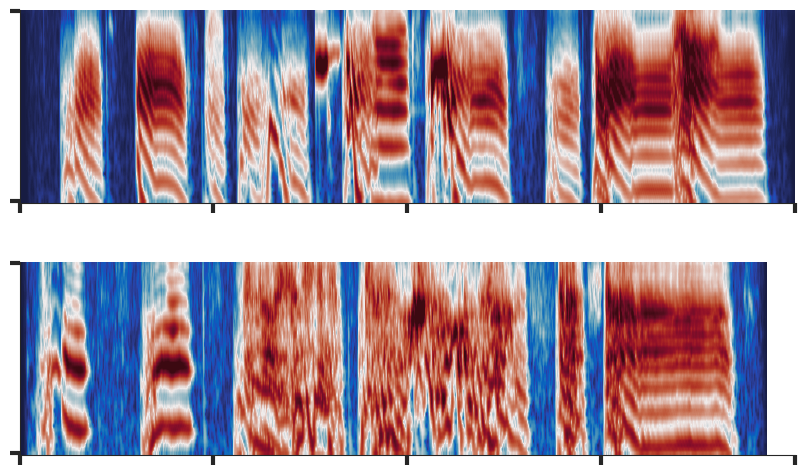

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

for im, m in enumerate(motifs[1:3]):
    # ax = plt.figure(figsize=(10,3)).add_subplot()
    stim = aname(m, 'C', 0)
    spec = spectrograms.loc[stim]
    tmax = spec.index.max()
    ticks = np.arange(0,tmax, 300)
    ax[im].imshow(
        spec.T.iloc[::-1], cmap=cmap, aspect=6, vmin=0, vmax=3
    )
    # for g, row in gaps.loc[m].iterrows():
    #     ga, gb = row
    #     ax[im].fill_between([ga, gb], y1=0, y2=49, color='gold', alpha=0.3)
    sns.despine(ax=ax[im], top=True, right=True)
    ax[im].set_xticks([0,300,600,900,1200],[])
    ax[im].set_yticks([0,49], [])
    ax[im].set_xlim(0,1200)

In [8]:
responses = pd.read_hdf(f"/scratch/bple/induction/{exp}_beta_delemb_win{win}_basis{nbasis}.h5", key="Induction")

models = joblib.load(f"/scratch/bple/induction/models/{exp}/beta_pls_model_win{win}_basis{nbasis}.pkl")
_, cs = get_scores(
    exp, models, spectrograms, responses, motifs, None,
    conditions, comparisons, full=False
)
cs['fam'] = 'beta'
cscores.append(cs.copy())
cscores = pd.concat(cscores).set_index(['fam','comp','ndim','motif','gap'])

Exp nat8a best # of components is 12


In [9]:
p1 = [0,2.5,5]
p2 = [1,3.5,6]
sns.set_style('whitegrid')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 2


In [10]:
e = gap_info[gap_info.early==1].index
l = gap_info[gap_info.early==0].index

f = gap_info[gap_info.full==1].index
p = gap_info[gap_info.full==0].index

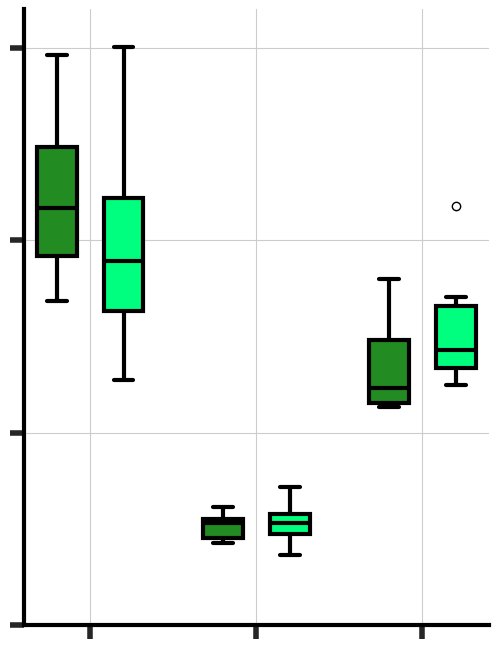

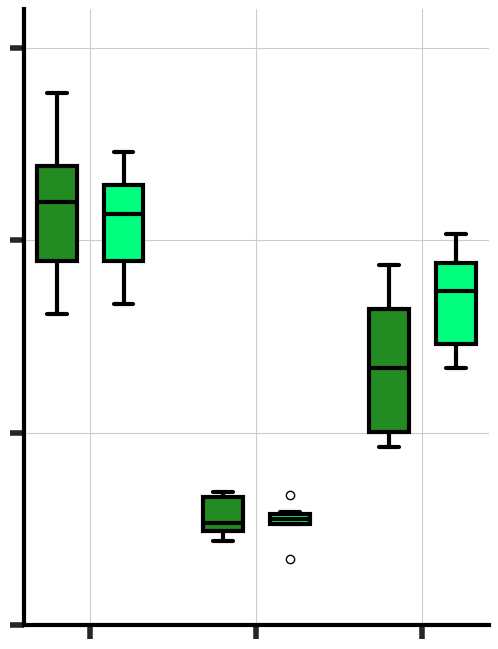

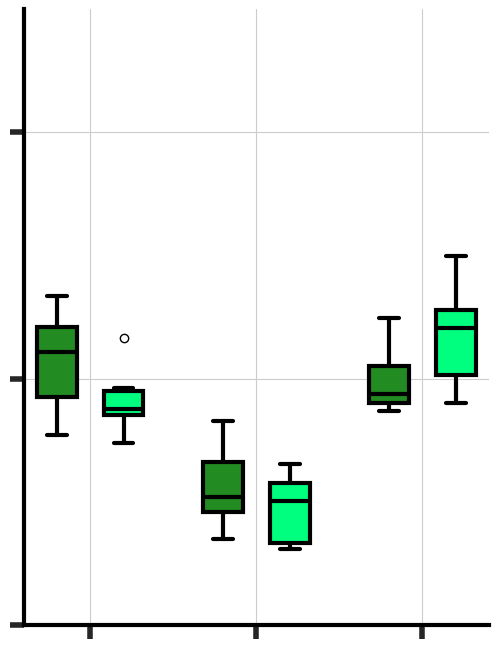

In [11]:
scores = cscores.droplevel('ndim')

for cond in ['familiar', 'unfamiliar', 'beta']:
    ax = plt.figure(figsize=(6,8)).add_subplot()
    
    bp1 = ax.boxplot(
        scores.loc[cond].unstack(0).droplevel(0,axis=1).loc[e],
        patch_artist=True,
        positions=p1,
        widths=0.6
    )
    bp2 = ax.boxplot(
        scores.loc[cond].unstack(0).droplevel(0,axis=1).loc[l],
        patch_artist=True,
        positions=p2,
        widths=0.6
    )
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp1[element], color='black', lw=3)
        plt.setp(bp2[element], color='black', lw=3)
    
    for patch in bp1['boxes']:
        patch.set(facecolor='forestgreen')
    for patch in bp2['boxes']:
        patch.set(facecolor='springgreen')

    sns.despine(ax=ax, top=True, right=True)
    plt.setp(ax.spines.values(), lw=3, color='black')
    if cond!='beta':
        ax.set_xticks([0.5,3,5.5], [])
        ax.set_yticks([0,0.5,1,1.5], [])
        ax.set_ylim(0,1.6)
        ax.set_xlim(-0.5, 6.5)
    else:
        ax.set_xticks([0.5,3,5.5], [])
        ax.set_yticks([0,1,2], [])
        ax.set_ylim(0,2.5)
        ax.set_xlim(-0.5, 6.5)

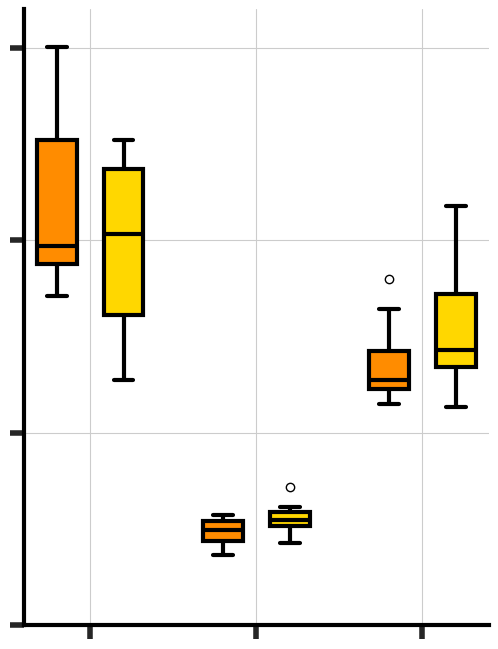

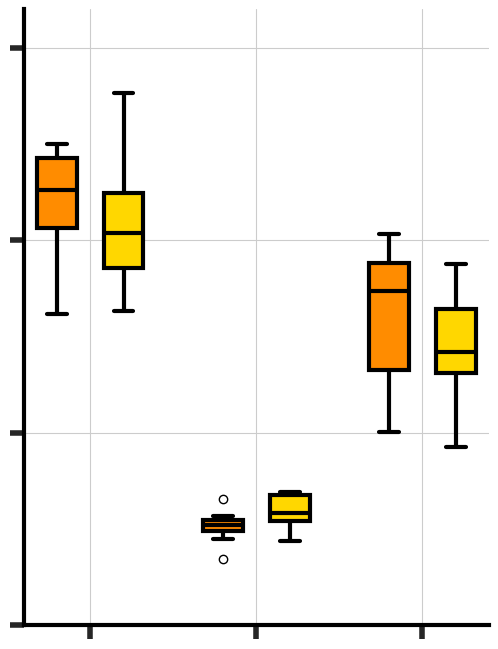

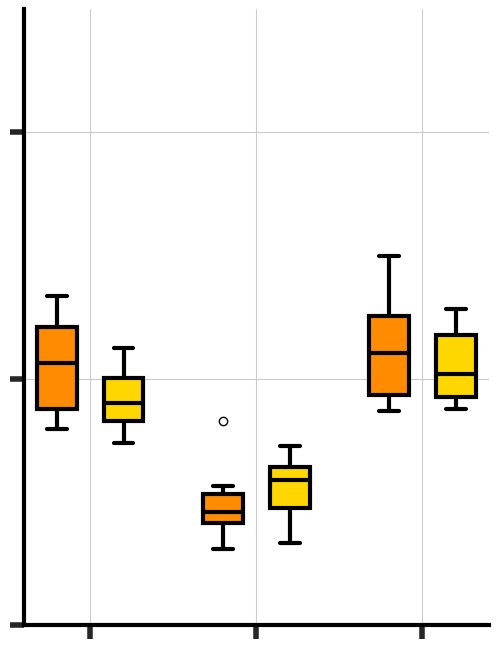

In [12]:
scores = cscores.droplevel('ndim')

for cond in ['familiar', 'unfamiliar', 'beta']:
    ax = plt.figure(figsize=(6,8)).add_subplot()
    
    bp1 = ax.boxplot(
        scores.loc[cond].unstack(0).droplevel(0,axis=1).loc[f],
        patch_artist=True,
        positions=p1,
        widths=0.6
    )
    bp2 = ax.boxplot(
        scores.loc[cond].unstack(0).droplevel(0,axis=1).loc[p],
        patch_artist=True,
        positions=p2,
        widths=0.6
    )
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp1[element], color='black', lw=3)
        plt.setp(bp2[element], color='black', lw=3)
    
    for patch in bp1['boxes']:
        patch.set(facecolor='darkorange')
    for patch in bp2['boxes']:
        patch.set(facecolor='gold')

    sns.despine(ax=ax, top=True, right=True)
    plt.setp(ax.spines.values(), lw=3, color='black')
    if cond!='beta':
        ax.set_xticks([0.5,3,5.5], [])
        ax.set_yticks([0,0.5,1,1.5], [])
        ax.set_ylim(0,1.6)
        ax.set_xlim(-0.5, 6.5)
    else:
        ax.set_xticks([0.5,3,5.5], [])
        ax.set_yticks([0,1,2], [])
        ax.set_ylim(0,2.5)
        ax.set_xlim(-0.5, 6.5)


In [13]:
exp = 'nat8b'
dataset = 'naive'
gtype = 'a' if exp=='synth8b' else ''
conditions = ['C','CB','GB','N','GM']
comparisons = [('GB','CB'),('GB','C'),('GB','N'),('GB','GM')]

with open(f'../../inputs/stimuli_lists/{exp}_motif_list.txt', 'r') as file:
    motifs = file.read().split('\n')
    
spectrograms = pd.read_csv(f"/scratch/bple/induction/{exp}/spectrograms.csv", index_col=[0,1])
gaps = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_gaptimes.csv', index_col=[0,1])
gaplocs = [1,2] if exp!='synth8b' else [2,4]

dsetdata = []
for h5file in glob.glob(f"/scratch/bple/induction/{exp}/{dataset}/**_delemb_win{win}_basis{nbasis}.h5"):
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)

models = joblib.load(f"/scratch/bple/induction/models/{exp}/{dataset}_pls_model_win{win}_basis{nbasis}.pkl")

_, bscores = get_scores(
    exp, models, spectrograms, responses, motifs, gtype,
    conditions, comparisons, full=False
)
bscores = bscores.set_index(['comp','ndim','motif','gap']).droplevel('ndim', axis=0)

Exp nat8b best # of components is 11


In [14]:
gap_info.index = gap_info.index.set_levels([f"nat8mk{m}" for m in range(8)], level=0)
e = gap_info[gap_info.early==1].index
l = gap_info[gap_info.early==0].index

f = gap_info[gap_info.full==1].index
p = gap_info[gap_info.full==0].index
gap_info.head()

start  stop  early  full
motif   gap                          
nat8mk0 1      113   209      1     1
        2      456   556      0     0
nat8mk7 1      629   729      1     0
        2      810   876      0     1
nat8mk5 1      328   428      1     0

(-0.5, 9.0)

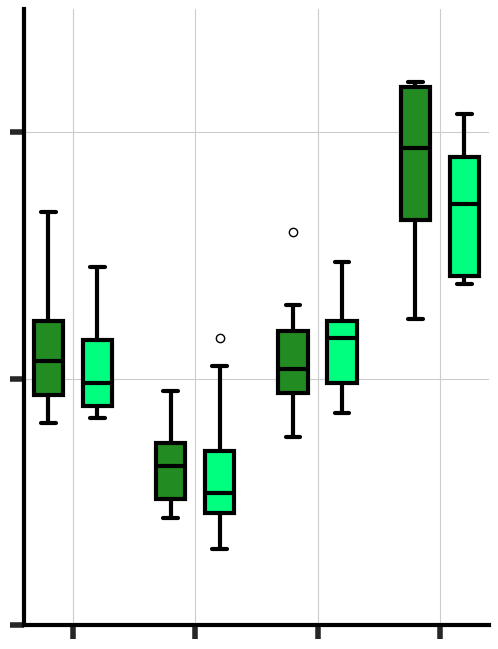

In [15]:
p1 = [0,2.5,5, 7.5]
p2 = [1,3.5,6, 8.5]
ax = plt.figure(figsize=(6,8)).add_subplot()
    
bp1 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[e],
    patch_artist=True,
    positions=p1,
    widths=0.6
)
bp2 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[l],
    patch_artist=True,
    positions=p2,
    widths=0.6
)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='black', lw=3)
    plt.setp(bp2[element], color='black', lw=3)

for patch in bp1['boxes']:
    patch.set(facecolor='forestgreen')
for patch in bp2['boxes']:
    patch.set(facecolor='springgreen')

sns.despine(ax=ax, top=True, right=True)
plt.setp(ax.spines.values(), lw=3, color='black')
ax.set_xticks([0.5,3,5.5,8], [])
ax.set_yticks([0,1,2], [])
ax.set_ylim(0,2.5)
ax.set_xlim(-0.5, 9)

(-0.5, 9.0)

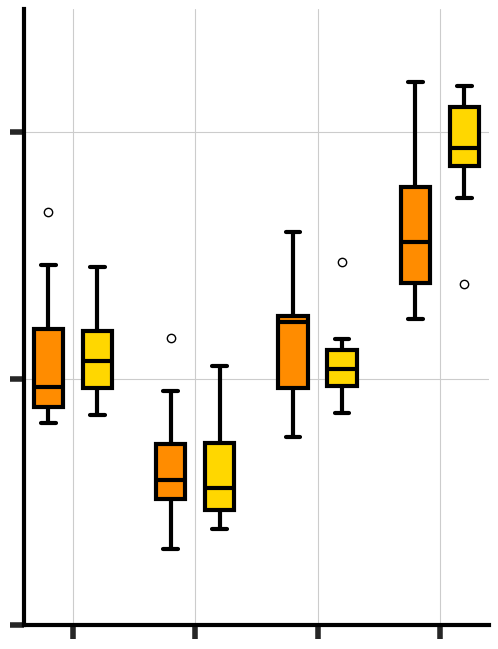

In [16]:
p1 = [0,2.5,5, 7.5]
p2 = [1,3.5,6, 8.5]
ax = plt.figure(figsize=(6,8)).add_subplot()
    
bp1 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[f],
    patch_artist=True,
    positions=p1,
    widths=0.6
)
bp2 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[p],
    patch_artist=True,
    positions=p2,
    widths=0.6
)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='black', lw=3)
    plt.setp(bp2[element], color='black', lw=3)

for patch in bp1['boxes']:
    patch.set(facecolor='darkorange')
for patch in bp2['boxes']:
    patch.set(facecolor='gold')

sns.despine(ax=ax, top=True, right=True)
plt.setp(ax.spines.values(), lw=3, color='black')
ax.set_xticks([0.5,3,5.5,8], [])
ax.set_yticks([0,1,2], [])
ax.set_ylim(0,2.5)
ax.set_xlim(-0.5, 9)

In [22]:
exp = 'synth8b'
dataset = 'naive'
gtype = 'a' if exp=='synth8b' else ''
conditions = ['C','CB','GB','N','GM']
comparisons = [('GB','CB'),('GB','C'),('GB','N'),('GB','GM')]

with open(f'../../inputs/stimuli_lists/{exp}_motif_list.txt', 'r') as file:
    motifs = file.read().split('\n')
    
spectrograms = pd.read_csv(f"/scratch/bple/induction/{exp}/spectrograms.csv", index_col=[0,1])
gaps = pd.read_csv(f'../../inputs/stimuli_lists/{exp}_gaptimes.csv', index_col=[0,1])
gaplocs = [1,2] if exp!='synth8b' else [2,4]

dsetdata = []
for h5file in glob.glob(f"/scratch/bple/induction/{exp}/{dataset}/**_delemb_win{win}_basis{nbasis}.h5"):
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)

models = joblib.load(f"/scratch/bple/induction/models/{exp}/{dataset}_pls_model_win{win}_basis{nbasis}.pkl")

_, bscores = get_scores(
    exp, models, spectrograms, responses, motifs, gtype,
    conditions, comparisons, full=False
)
bscores = bscores.set_index(['comp','ndim','motif','gap']).droplevel('ndim', axis=0)

Exp synth8b best # of components is 11


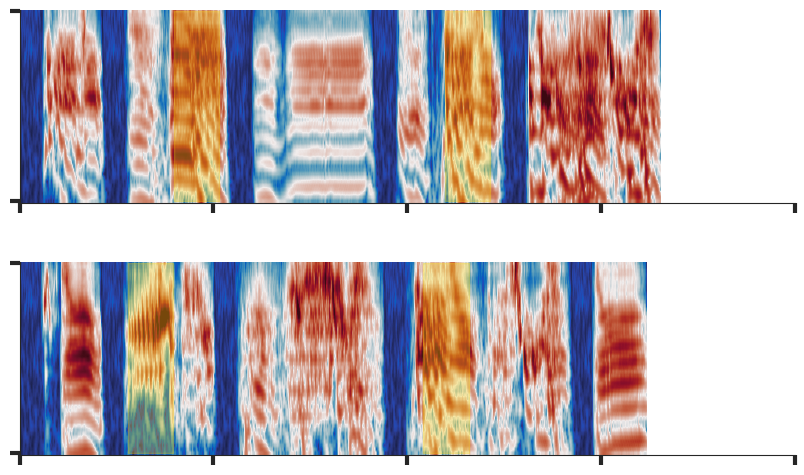

In [23]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.minor.width'] = 2

fig, ax = plt.subplots(2,1, figsize=(10,6))

for im, m in enumerate(motifs[2:4]):
    # ax = plt.figure(figsize=(10,3)).add_subplot()
    stim = bname(m, 'C', 0)
    spec = spectrograms.loc[stim]
    tmax = spec.index.max()
    ticks = np.arange(0,tmax, 300)
    ax[im].imshow(
        spec.T.iloc[::-1], cmap=cmap, aspect=6, vmin=0, vmax=3
    )
    for g, row in gaps.loc[m].iterrows():
        ga, gb = row
        ax[im].fill_between([ga, gb], y1=0, y2=49, color='gold', alpha=0.3)
    sns.despine(ax=ax[im], top=True, right=True)
    ax[im].set_xticks([0,300,600,900,1200],[])
    ax[im].set_yticks([0,49], [])
    ax[im].set_xlim(0,1200)

In [19]:
gaps['early'] = 0
gaps.loc[gaps.groupby('motif').apply(
    lambda x: x.gap_start.idxmin()
).values, 'early'] = 1
e = gaps[gaps.early==1].index
l = gaps[gaps.early!=1].index

(-0.5, 9.0)

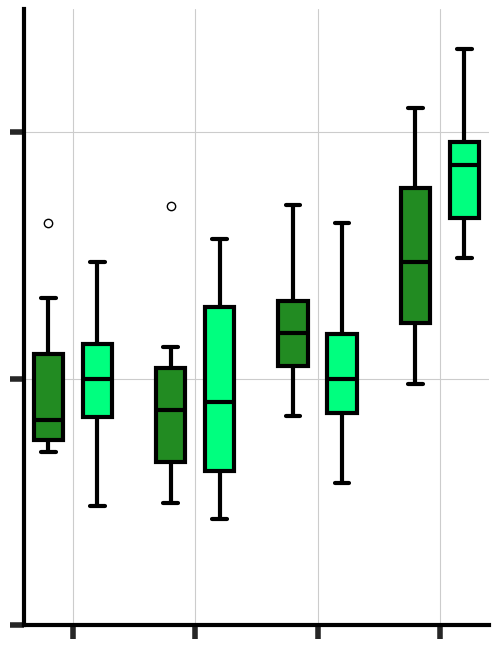

In [20]:
p1 = [0,2.5,5, 7.5]
p2 = [1,3.5,6, 8.5]
sns.set_style('whitegrid')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.minor.width'] = 2

ax = plt.figure(figsize=(6,8)).add_subplot()
    
bp1 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[e],
    patch_artist=True,
    positions=p1,
    widths=0.6
)
bp2 = ax.boxplot(
    bscores.unstack('comp').droplevel(0,axis=1).loc[l],
    patch_artist=True,
    positions=p2,
    widths=0.6
)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp1[element], color='black', lw=3)
    plt.setp(bp2[element], color='black', lw=3)

for patch in bp1['boxes']:
    patch.set(facecolor='forestgreen')
for patch in bp2['boxes']:
    patch.set(facecolor='springgreen')

sns.despine(ax=ax, top=True, right=True)
plt.setp(ax.spines.values(), lw=3, color='black')
ax.set_xticks([0.5,3,5.5,8], [])
ax.set_yticks([0,1,2], [])
ax.set_ylim(0,2.5)
ax.set_xlim(-0.5, 9)